## Method for extracting and cleaning dataset

In [12]:
from os import path
from os import getcwd, listdir
path_to_data = path.join('..', 'data', 'houses')
houses = listdir(path_to_data)

## Select a house
| HouseID   |   Load        |
|---------  |   ------      |
|64613      |   hot_water   |
|70210      |   pool        |
|70243      |   hot_water   |
|70277      |   hot_water   |
|91912      |   pool        |
|91910      |   hot_water   |

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import thesisInitial.tariff as tf
sns.set()
house_id = 70243

### Importing Data and cleaning up

In [14]:
df = pd.read_csv(path.join(path_to_data,str(house_id)+'.csv'))
df.drop(columns=['Unnamed: 0'], inplace=True)
df.drop_duplicates(keep='first', inplace=True)
df['reading_datetime'] = pd.to_datetime(df['reading_datetime'])
df.set_index('reading_datetime', inplace=True)
df.sort_index(inplace=True)
df['circuit_id_monitor'] = df.circuit_id.astype(str) + ' <<' +df.monitors+'>>'

original_set = df.reset_index()
original_set = original_set.pivot(index='reading_datetime', columns='circuit_id_monitor', values=['energy', 'energy_pos', 'energy_neg'])
net_energy = original_set[:]['energy']

# print('Setup Complete')


for m in df.monitors.unique():
    print(m)

pv_site_net
ac_load_net
load_air_conditioner
load_hot_water_solar
load_powerpoint
load_hot_water


#### Select monitor to analyse

In [15]:
load_type = 'hot_water'
print(load_type)


hot_water


### Analysing the Total Consumption over the Year

#### Step 1. Get the load on its own

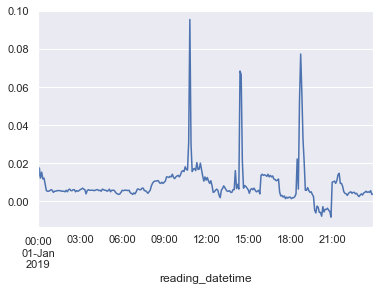

In [16]:
#get load by itself
load = net_energy.filter(regex=load_type).sum(axis=1)
load[str(net_energy.index[0].date())].plot()
plt.show()

#### Step 2. Get the net of PV and AC summed over all the monitors
The total household consumption can be preliminarily calculated as the sum of the total AC net and PV net, cancelling out the energy generated by the PV

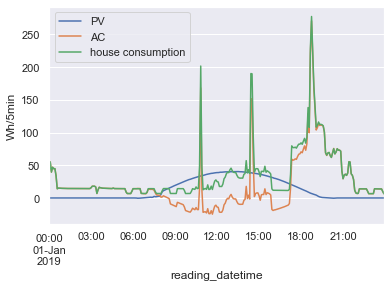

In [17]:
pv_net = net_energy.filter(regex='pv').sum(axis=1)
ac_net = net_energy.filter(regex='ac_load_net').sum(axis=1)
house_consumption = ac_net + pv_net

pv_net[str(net_energy.index[0].date())].plot(label='PV')
ac_net[str(net_energy.index[0].date())].plot(label='AC')
house_consumption[str(net_energy.index[0].date())].plot(label='house consumption')
plt.ylabel('Wh/5min')
plt.legend()
plt.show()

#### Step 3. Work out whether the Load is included in the AC Net
This is done by taking the differential of both the load and the AC Net and checking how well the changes in load and AC net align.

If the spikes in Load and AC net align greater than 95% of the time the load can be assumed to be in the AC net.

This means we can find the true consumption for the house by either including or not including the load to the AC net.

The total import and export energy can also be found and the household consumption without the load.

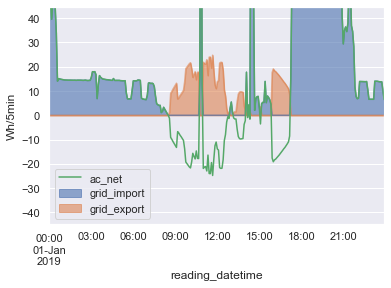

In [18]:
# removes the PV component to expose
house_consumption_diff = house_consumption.diff()
load_diff = load.diff()
house_spikes = (house_consumption_diff.abs() > house_consumption_diff.std())
load_spikes = (load_diff.abs() > load_diff.std())
aligned = load_spikes & house_spikes


if aligned.sum() / load_spikes.sum() > 0.05:
    house_consumption = house_consumption
    grid_import = ac_net.clip(lower=0)
    grid_export = (ac_net * - 1).clip(lower=0)


else:
    house_consumption = house_consumption + load
    grid_import = (ac_net + load).clip(lower=0)
    grid_export = ((ac_net + load)* - 1).clip(lower=0)

house_consumption_without_load = house_consumption - load

grid_import[str(net_energy.index[0].date())].plot.area(label='grid_import', alpha=0.6)
grid_export[str(net_energy.index[0].date())].plot.area(label='grid_export', alpha=0.6)
ac_net[str(net_energy.index[0].date())].plot(label='ac_net')
plt.legend()
plt.ylabel('Wh/5min')
plt.ylim(bottom=min(ac_net[str(net_energy.index[0].date())]) - 20, top=max(grid_export[str(net_energy.index[0].date())]) + 20)
plt.show()

#### Step 4. Calculate the total PV utilisation
PV utilisation is the amount of PV generation that is used within the home.

This is calculated as the lower of the generation or the household consumption when the PV are generating.

$ PV utilisation = min(PV_gen, household_consumption) $


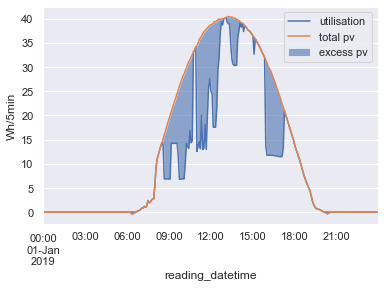

In [19]:
# floored at zero to make plots nicer
pv_utilisation = pd.concat([pv_net, house_consumption], axis=1).min(axis=1).clip(lower=0)
ax=pv_utilisation[str(net_energy.index[0].date())].plot(label='utilisation')
pv_net[str(net_energy.index[0].date())].plot(label='total pv',ax=ax)
x = pv_net[str(net_energy.index[0].date())].index
y1 = pv_net[str(net_energy.index[0].date())]
y2 = pv_utilisation[str(net_energy.index[0].date())]
ax.fill_between(x, y2, y1, alpha=0.6, label='excess pv')
plt.ylabel('Wh/5min')
plt.legend()
plt.show()

### Tariff Choices
There are 4 Tariff Categories Currently
<li> flat
<li> Time of Use (TOU)
<li> Flat with controlled Load
<li> TOU with controlled load

In [20]:
tariff_type = 'TOU'
tariffs = tf.read_tariffs()

tariff = None
for t in tariffs:
    if t.tariff_type == tariff_type:
        tariff = t

print("Tariff Name: " + tariff.tariff_name)


Tariff Name: OriginGo


### Conclusion
The total consumption and the import and export are listed below

The house PV utilisation is included as well

The day the house used the load the longest is presented as a chart to illustrate the information extracted

House Usage Total		3844.37kWh
Import total			2963.70kWh
Export total			3085.93kWh
Import Cost			1066.48
Export Revneue			246.87
Net				819.60

PV total			3966.60kWh
PV self consumed total		885.80kWh
PV exported			3080.80kWh
PV utilisation			22.33%


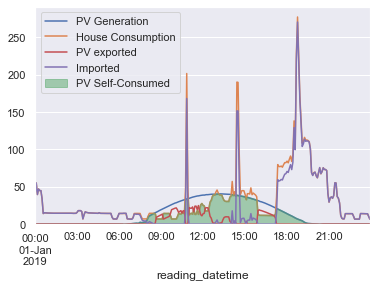

In [29]:
house_consumption_total = house_consumption.sum() / 1000
pv_gen_total = pv_net.sum() / 1000
grid_import_total = grid_import.sum() / 1000
grid_export_total = grid_export.sum() / 1000
pv_utilisation_total = pv_utilisation.sum() /1000
grid_import = grid_import.rename('grid_import')
load = load.rename('load')
import_cost = tariff.get_cost(pd.concat([grid_import/1000, load/1000], axis=1))
total_import_cost = import_cost.sum() / 100
export_revenue = tariff.get_fit() * (grid_export / 1000)
total_export_revenue = export_revenue.sum() / 100

export = pv_net - pv_utilisation
export_total = export.sum() / 1000

print("House Usage Total\t\t" + "{:.2f}".format(house_consumption_total) + "kWh")
print("Import total\t\t\t" + "{:.2f}".format(grid_import_total) + "kWh")
print("Export total\t\t\t" + "{:.2f}".format(grid_export_total) + "kWh")
print("Import Cost\t\t\t" + "{:.2f}".format(total_import_cost))
print("Export Revneue\t\t\t" + "{:.2f}".format(total_export_revenue))
print('Net\t\t\t\t' + "{:.2f}".format(total_import_cost - total_export_revenue))
print()
print("PV total\t\t\t" + "{:.2f}".format(pv_gen_total) + "kWh")
print("PV self consumed total\t\t" + "{:.2f}".format(pv_utilisation_total) + "kWh")
print("PV exported\t\t\t" + "{:.2f}".format(export_total) + "kWh")
print("PV utilisation\t\t\t" + "{:.2f}".format((pv_utilisation_total / pv_gen_total) * 100) + "%")

pv_net[str(net_energy.index[0].date())].plot(label='PV Generation')
house_consumption[str(net_energy.index[0].date())].plot(label='House Consumption')
pv_utilisation[str(net_energy.index[0].date())].clip(lower=0).plot.area(alpha=0.5, label='PV Self-Consumed')
export[str(net_energy.index[0].date())].plot(label='PV exported')
# grid_export[str(longest_day.date())].plot(label='Exported')
grid_import[str(net_energy.index[0].date())].plot(label='Imported')
plt.legend()
plt.show()

### Calculated how much of the load is serviced by PV after servicing all other loads in the house



In [22]:
house_consumption_when_loadon_pvgen = np.where(((pv_net > 1) & (load > 10)), pv_utilisation, 0)
load_serviced_by_PV = (house_consumption_when_loadon_pvgen - house_consumption_without_load).clip(lower=0)

print("load total " + "{:.2f}".format(load.sum() / 1000) + "kWh")
print("load serviced by PV Total " + "{:.2f}".format(load_serviced_by_PV.sum() / 1000) + "kWh")

load total 855.28kWh
load serviced by PV Total 24.40kWh


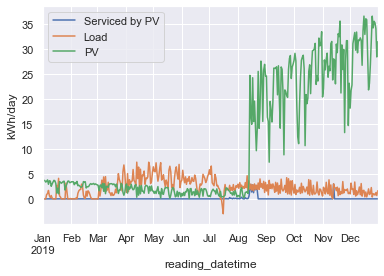

In [23]:
load_serviced_by_PV_24h = load_serviced_by_PV.resample('24h').sum() / 1000
load_24h = load.resample('24h').sum() / 1000
pv_24h = pv_net.resample('24h').sum() / 1000

load_serviced_by_PV_24h.plot(label='Serviced by PV')
load_24h.plot(label='Load')
pv_24h.plot(label='PV')
plt.legend()
plt.ylabel('kWh/day')
plt.show()
